In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import xarray as xr
from datetime import datetime

# warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# ICPW Thematic Report 2020 - Nitrogen (Part 6: Annual temperature and precipitation)

## 1. Get stations

In [2]:
# Read stations
stn_path = r"../data/all_icpw_sites_may_2020.xlsx"
stn_df = pd.read_excel(stn_path, sheet_name="all_icpw_stns")

# Check stn numbers seem OK
trend_df = stn_df.query("group in ('Trends', 'Trends+Core')")
core_df = stn_df.query("group in ('Core', 'Trends+Core')")

print(f"There are {len(stn_df)} unique stations within the ICPW project as a whole.")
stn_df.head()

There are 556 unique stations within the ICPW project as a whole.


,station_id,station_code,station_name,latitude,longitude,altitude,continent,country,region,group
0,38115,Tr18_CA_DO1,Blue Chalk Lake,45.1999,-78.9432,344.0,North America,Canada,Ont,Trends
1,38116,Tr18_CA_DO2,Chub Lake,45.2138,-78.9836,343.0,North America,Canada,Ont,Trends
2,38117,Tr18_CA_DO3,Crosson Lake,45.0840,-79.0360,371.0,North America,Canada,Ont,Trends
3,38118,Tr18_CA_DO4,Dickie Lake,45.1510,-79.0876,379.0,North America,Canada,Ont,Trends
4,38119,Tr18_CA_DO5,Harp Lake,45.3798,-79.1335,327.0,North America,Canada,Ont,Trends


## 2. Read climate data

In [3]:
def del_stn(ds):
    """ Preprocessing for CRU climate datasets.
    """
    if "stn" in ds.variables:
        del ds["stn"]
    return ds

In [4]:
cru_path = (
    r"/home/jovyan/shared/01_datasets/climate/cru_ts4-03_gridded_climatology/*.nc"
)
ds = xr.open_mfdataset(cru_path, combine="by_coords", preprocess=del_stn)
ds

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720, time: 1416)
Coordinates:
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2018-12-16
Data variables:
    pre      (time, lat, lon) float32 dask.array<chunksize=(1416, 360, 720), meta=np.ndarray>
    tmp      (time, lat, lon) float32 dask.array<chunksize=(1416, 360, 720), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.03 Precipitation
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 1905011326. Data generated from:pre.1905011321.dtb
    history:      Thu  2 May 2019 06:31:34 BST : User ianharris : Program mak...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk

In [5]:
st_yr = 1992

# Aggregate to annual
pre = ds["pre"].resample(time="A").sum()
tmp = ds["tmp"].resample(time="A").mean()

ds = xr.merge([pre, tmp])

# Set zero pptn to NaN
ds['pre'] = ds['pre'].where(ds['pre'] != 0)

# Just 1990 to 2016
ds["time"] = ds["time"].dt.year
ds = ds.where((ds["time"] >= st_yr) & (ds["time"] <= 2016), drop=True)

# Load into memory (from Dask)
ds = ds.load()

/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## 3. Extract time series for stations

In [6]:
# Loop over sites
df_list = []
for idx, row in stn_df.iterrows():
    lat = row["latitude"]
    lon = row["longitude"]
    stn_id = row["station_id"]

    # Get time series
    df = ds.sel(lat=lat, lon=lon, method="nearest").to_dataframe().reset_index()
    df["station_id"] = stn_id
    df["year"] = df["time"]

    df_list.append(df)

# Combine results
df = pd.concat(df_list, sort=True).reset_index(drop=True)
df = df[["station_id", "year", "pre", "tmp"]]
df = df.melt(id_vars=['station_id', 'year'])

# Save
df.to_csv(f"./results/climate/cru_climate_timeseries_icpw_stns_{st_yr}-2016.csv", index=False)

df.head()

,station_id,year,variable,value
0,38115,1992,pre,1216.000000
1,38115,1993,pre,1090.300049
2,38115,1994,pre,1109.599976
3,38115,1995,pre,1168.300049
4,38115,1996,pre,1218.199951


## 4. Plots

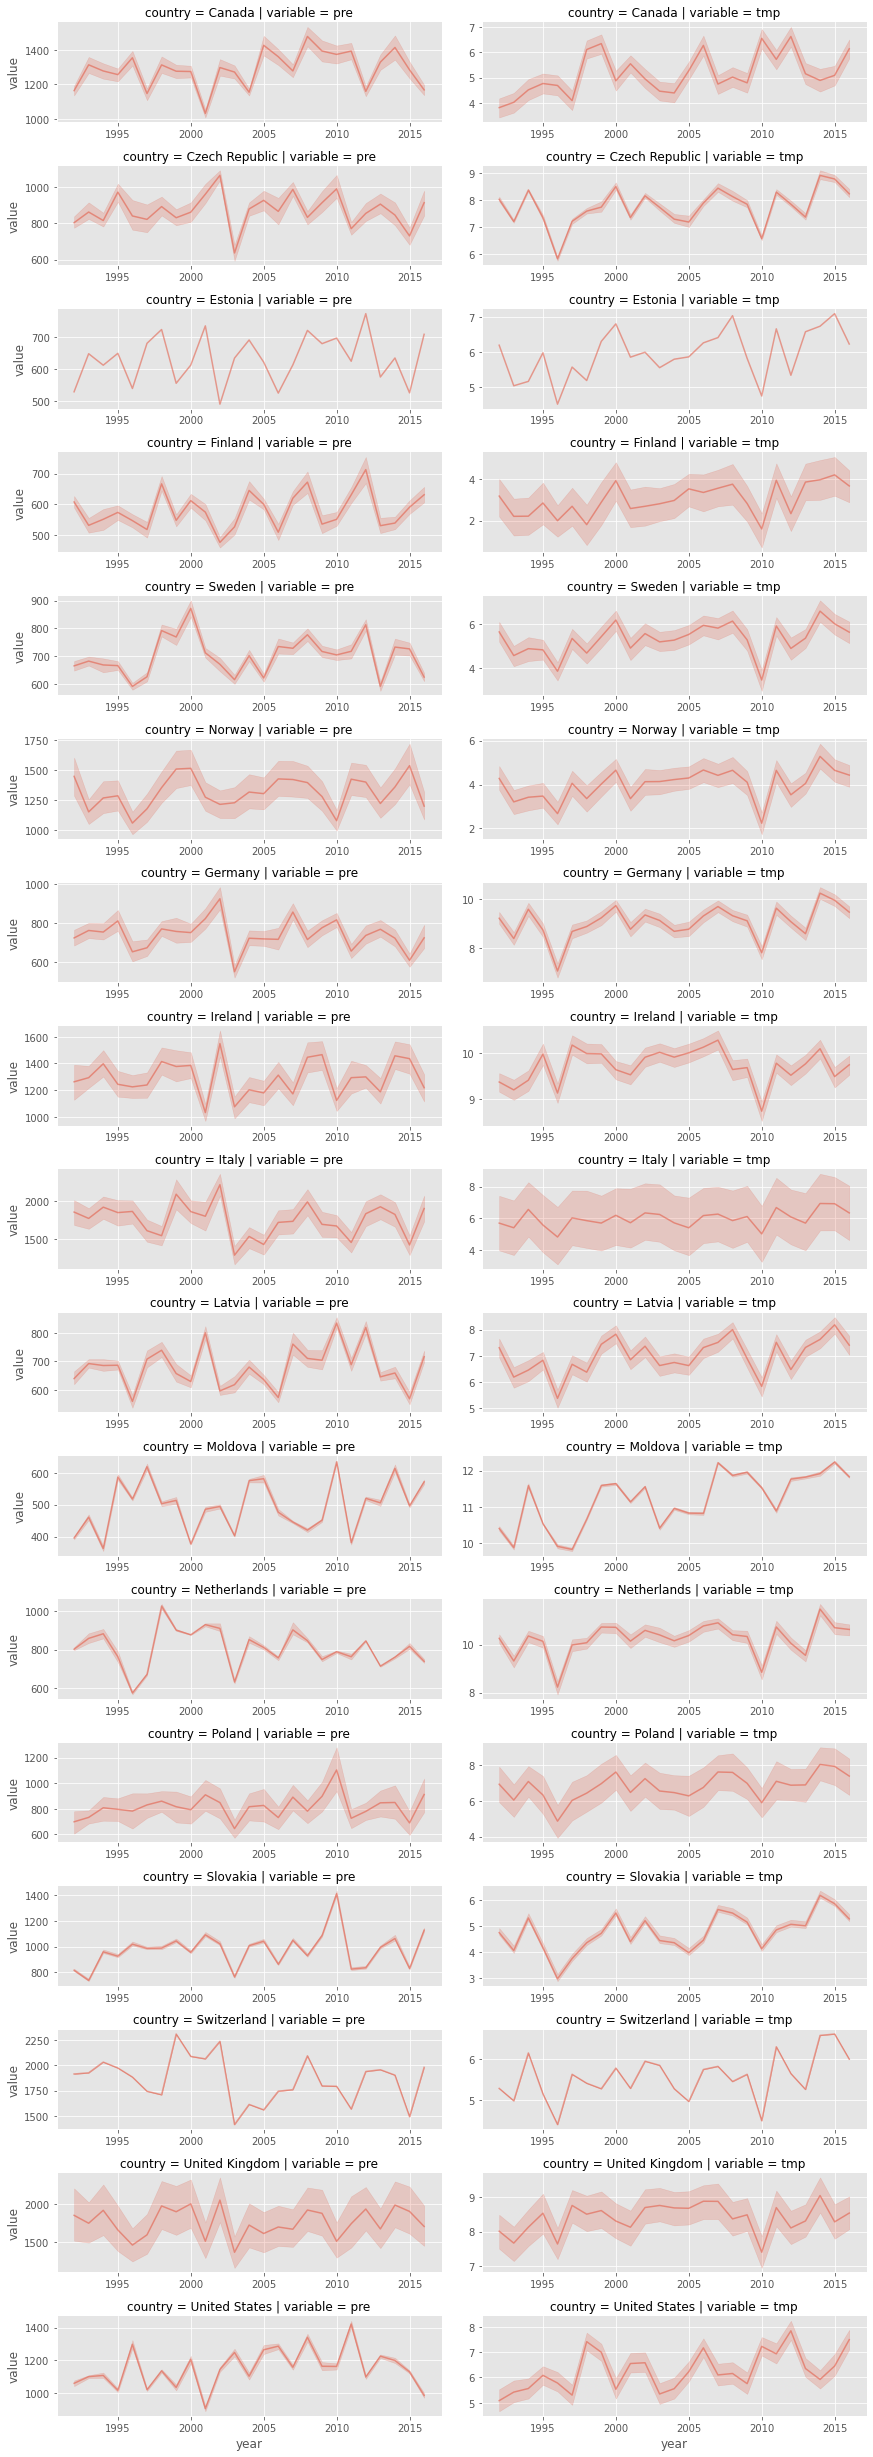

In [7]:
# Add country
df = pd.merge(df, stn_df[['station_id', 'country']], how='left', on='station_id')

# Plot
sn.relplot(
    data=df,
    x="year",
    y="value",
    row="country",
    col='variable',
    height=2,
    aspect=3,
    kind="line",
    legend=False,
    alpha=0.5,
    facet_kws={'sharey': False, 'sharex': False},
)

## 5. Trends

In [8]:
# Dict for results
res_dict = {
    "station_id": [],
    "variable": [],
    "median": [],
    "mk_p_val": [],
    "mk_trend": [],
    "sen_slp": [],
    "sen_incpt": [],
    "sen_trend": [],
}

for stn_id in df['station_id'].unique():
    # Setup plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

    for idx, par in enumerate(['pre', 'tmp']):
        df2 = df.query("(station_id == @stn_id) and (variable == @par)")
        df2.set_index("year", inplace=True)
        df2.sort_index(inplace=True)

        # MK test
        mk_df = nivapy.stats.mk_test(df2, 'value')

        # Sen's slope
        res_df, sen_df = nivapy.stats.sens_slope(
            df2, value_col='value', index_col=df2.index
        )

        # Add results to dict
        res_dict["station_id"].append(stn_id)
        res_dict["variable"].append(par)
        res_dict["median"].append(df2['value'].median())
        res_dict["mk_p_val"].append(mk_df.loc["p"].value)
        res_dict["mk_trend"].append(mk_df.loc["trend"].value)

        sslp = res_df.loc["sslp"].value
        sincpt = res_df.loc["icpt"].value
        res_dict["sen_slp"].append(sslp)
        res_dict["sen_incpt"].append(sincpt)
        res_dict["sen_trend"].append(res_df.loc["trend"].value)

        # Plot
        axes[idx].plot(sen_df.index, sen_df['value'].values, "bo-")
        axes[idx].plot(sen_df.index, sen_df.index * sslp + sincpt, "k-")

        axes[idx].set_title(par)
        axes[idx].set_xlim((st_yr, 2016))

    # Save plot
    plt.tight_layout()
    png_path = f"./results/climate/stn_{stn_id}_pre_tmp_trends.png"
    plt.savefig(png_path, dpi=200)
    plt.close()
        
# Combine results
res_df = pd.DataFrame(res_dict)

# Save
csv_path = f"./results/climate/cru_climate_trends_icpw_stns.csv"
res_df.to_csv(csv_path, index=False)

res_df.head()

,station_id,variable,median,mk_p_val,mk_trend,sen_slp,sen_incpt,sen_trend
0,38115,pre,1168.300049,0.591154,no trend,1.447623,-1732.736677,no trend
1,38115,tmp,4.891667,0.029855,increasing,0.055137,-105.603498,increasing
2,38116,pre,1168.300049,0.591154,no trend,1.447623,-1732.736677,no trend
3,38116,tmp,4.891667,0.029855,increasing,0.055137,-105.603498,increasing
4,38117,pre,1070.500122,0.293271,no trend,1.012895,-959.341435,no trend
